# Synthetic Causal Validation

This notebook serves as a controlled experiment to validate the core capabilities of our GNN-NCM. We will create a synthetic world with known, non-linear causal laws. Our goal is to rigorously test if our proposed model can successfully learn these mechanisms from observational data, a task where we expect simpler, non-causal models to fail.

This notebook will:
* Generate a synthetic dataset with a known causal graph and ground-truth mechanisms.
* Train our GNN-NCM and baseline models on this data.
* Evaluate the models on two key criteria:
* Predictive Robustness: How well does each model perform under a synthetic "shock"?
* Causal Fidelity: How accurately does each model recover the true Average Treatment Effect (ATE) of an intervention?

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# PyTorch Geometric imports
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader


# --- CONFIGURATION & PATHS ---
set_seed = lambda seed: (np.random.seed(seed), torch.manual_seed(seed))
set_seed(42)

from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))  

SYNTHETIC_DATA_DIR = PROJECT_ROOT / "data" / "synthetic_validation"
SYNTHETIC_DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root detected at: {PROJECT_ROOT}")
print(f"Synthetic data will be saved to: {SYNTHETIC_DATA_DIR}")

from src.models import GNN_NCM, BaselineGCN
from src.trainer import CausalTwoPartTrainer 


c:\Users\asus\miniconda3\envs\ai_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project Root detected at: C:\Users\asus\OneDrive\Desktop\thesis
Synthetic data will be saved to: C:\Users\asus\OneDrive\Desktop\thesis\data\synthetic_validation


### Creating Synthetic Data

In [2]:
# --- 1. Define Graph Structure ---
nodes = ["Mom", "HML", "OI", "PC", "BAS", "LIQ", "VOL"]
node_mapping = {name: i for i, name in enumerate(nodes)}
edges = [
    ('Mom', 'HML'), ('Mom', 'PC'), ('HML', 'OI'), ('OI', 'PC'),
    ('OI', 'BAS'), ('PC', 'BAS'), ('BAS', 'LIQ'), ('BAS', 'VOL')
]
edge_index = torch.tensor([[node_mapping[src], node_mapping[dst]] for src, dst in edges], dtype=torch.long).t().contiguous()

# --- 2. Define Ground-Truth Causal Laws ---
causal_relationships = {
    'HML': {'Mom': 0.5}, 'OI': {'HML': 0.7},
    'PC':  {'Mom': 0.3, 'OI': 0.6},
    'BAS': {'OI': 0.4, 'PC': 0.6}, # This will be non-linear (tanh)
    'LIQ': {'BAS': -0.8}, 'VOL': {'BAS': 0.9}
}
NOISE_STD = 0.1

# --- 3. Generate Node Features and Labels ---
num_nodes, num_features = 7, 1
x = torch.randn(num_nodes, num_features)
y = torch.zeros(num_nodes, 1)

# Generate labels based on the true causal laws
for node_name, parents in causal_relationships.items():
    child_idx = node_mapping[node_name]
    parent_effects = 0
    for parent_name, coeff in parents.items():
        parent_idx = node_mapping[parent_name]
        # We use the mean of the parent's feature vector as its "value"
        parent_effects += x[parent_idx].mean() * coeff
    
    if node_name == 'BAS': # Introduce non-linearity
        parent_effects = torch.tanh(parent_effects)
        
    y[child_idx] = parent_effects + torch.randn(1) * NOISE_STD

# Create the single, static Data object
graph_data = Data(x=x, edge_index=edge_index, y=y)
print("Synthetic 'photographic' graph created successfully.")
print(graph_data)

Synthetic 'photographic' graph created successfully.
Data(x=[7, 1], edge_index=[2, 8], y=[7, 1])


### Creating a Synthetic Dataset

In [3]:
class SyntheticGraphDataset(Dataset):
    def __init__(self, num_graphs=50, num_nodes=7, feature_dim=4,
                 edge_index=None, causal_relationships=None,
                 node_mapping=None, noise_std=0.1, seed=0):
        super().__init__()
        self.num_graphs = num_graphs
        self.num_nodes = num_nodes
        self.feature_dim = feature_dim  # <-- renamed, no clash
        self.edge_index = edge_index
        self.causal_relationships = causal_relationships
        self.node_mapping = node_mapping
        self.noise_std = noise_std

        g = torch.Generator().manual_seed(seed)
        self._xs = torch.randn(num_graphs, num_nodes, feature_dim, generator=g)

    def __len__(self):
        return self.num_graphs

    def __getitem__(self, idx):
        x = self._xs[idx].clone()
        y = torch.zeros(self.num_nodes, 1)

        for node_name, parents in self.causal_relationships.items():
            child_idx = self.node_mapping[node_name]
            parent_effects = 0.0
            for parent_name, coeff in parents.items():
                parent_idx = self.node_mapping[parent_name]
                parent_effects += x[parent_idx].mean() * coeff
            if node_name == 'BAS':
                parent_effects = torch.tanh(parent_effects)
            y[child_idx] = parent_effects + torch.randn(1) * self.noise_std

        return Data(x=x, edge_index=self.edge_index, y=y)


# ------------------ example usage ------------------
# assumes you already defined:
#   - causal_relationships: dict[str, dict[str, float]]
#   - node_mapping: dict[str, int]
#   - edge_index: torch.LongTensor [2, E]
#   - NOISE_STD: float

# assumes you already defined causal_relationships, node_mapping, edge_index, NOISE_STD
ds = SyntheticGraphDataset(
    num_graphs=100,
    num_nodes=7,
    feature_dim=1,
    edge_index=edge_index,
    causal_relationships=causal_relationships,
    node_mapping=node_mapping,
    noise_std=NOISE_STD,
    seed=123,
)

print(len(ds))
print(ds[0])  # first synthetic graph


100
Data(x=[7, 1], edge_index=[2, 8], y=[7, 1])


### Training

In [ ]:
from torch.utils.data import random_split

best_params = {'hidden_dim': 32, 'out_dim': 16,}
models = {}
num_edges = graph_data.edge_index.size(1)

n_train = int(0.8 * len(ds))
n_val   = len(ds) - n_train
ds_train, ds_val = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(7))

train_loader = DataLoader(ds_train, batch_size=1, shuffle=True)  # keep 1 if graphs vary
val_loader   = DataLoader(ds_val,   batch_size=1, shuffle=False)

# infer dims from one batch
g0 = next(iter(train_loader))
num_features = g0.num_features
num_edges    = g0.edge_index.size(1)
best_params  = {'hidden_dim': 32, 'out_dim': 16}

device = g0.x.device

# --- Train all three models ---

# 1. GNN-NCM (per-edge)
print("\n--- Training GNN-NCM (per-edge) ---")
model_per_edge = GNN_NCM(num_features=num_features, num_edges=num_edges, gnn_mode='per_edge', **best_params)
trainer_per_edge = CausalTwoPartTrainer(epochs_obs=40, epochs_do=20, w_obs=0.2, w_do=1.0)
trainer_per_edge.train(model_per_edge, train_loader, val_loader=val_loader)
val_loss_pe = trainer_per_edge.evaluate_obs_mse(model_per_edge, val_loader)
print(f"[per-edge] val_mse={val_loss_pe:.6f}")
models['GNN-NCM (per-edge)'] = model_per_edge

# 2. GNN-NCM (shared) - An ablation study
print("\n--- Training GNN-NCM (shared) ---")
model_shared = GNN_NCM(num_features=num_features, num_edges=num_edges, gnn_mode='shared', **best_params)
trainer_shared = CausalTwoPartTrainer(epochs_obs=40, epochs_do=20, w_obs=0.2, w_do=1.0)

trainer_shared.train(model_shared, train_loader, val_loader=val_loader)
val_loss_pe = trainer_shared.evaluate_obs_mse(model_shared, val_loader)
print(f"[shared] val_mse={val_loss_pe:.6f}")
models['GNN-NCM (shared)'] = model_shared


# 3. Baseline GCN - A standard, non-causal GNN
print("\n--- Training BaselineGCN ---")
baseline_model = BaselineGCN(num_features=num_features, hidden_dim=best_params['hidden_dim'], out_dim=best_params['out_dim'])
optimizer_baseline = optim.Adam(baseline_model.parameters())
loss_fn_baseline = nn.MSELoss()

for ep in range(200):
    for g in train_loader:
        g = g.to(device)
        baseline_model.train(); optimizer_baseline.zero_grad()
        pred = baseline_model(g.x, g.edge_index)
        loss = loss_fn_baseline(pred, g.y)
        loss.backward(); optimizer_baseline.step()
    if (ep+1) % 40 == 0:
        print(f"[Baseline] ep {ep+1:03d} loss={loss.item():.4f}")

# quick baseline val
baseline_model.eval()
with torch.no_grad():
    total = 0.0; n = 0
    for g in val_loader:
        g = g.to(device)
        total += float(((baseline_model(g.x, g.edge_index) - g.y)**2).mean().item())
        n += 1
val_loss_bl = total / max(n,1)
print(f"[baseline] val_mse={val_loss_bl:.6f}")


models['BaselineGCN'] = baseline_model



--- Training GNN-NCM (per-edge) ---
[obs 010] obs=0.029599 | val_obs=0.017225
[obs 020] obs=0.020426 | val_obs=0.019797
[obs 030] obs=0.019495 | val_obs=0.019846
[obs 040] obs=0.020086 | val_obs=0.030947
[do  010] total=0.410671 (obs=0.059173, do=0.398836) | val_obs=0.049298
[do  020] total=0.391961 (obs=0.049401, do=0.382080) | val_obs=0.047097
[per-edge] val_mse=0.047155

--- Training GNN-NCM (shared) ---
[obs 010] obs=0.284260 | val_obs=0.229195
[obs 020] obs=0.299962 | val_obs=0.203089
[obs 030] obs=0.257586 | val_obs=0.216213
[obs 040] obs=0.253304 | val_obs=0.190692
[do  010] total=0.470829 (obs=0.292229, do=0.412383) | val_obs=0.197192
[do  020] total=0.446106 (obs=0.256752, do=0.394756) | val_obs=0.197605
[shared] val_mse=0.213592

--- Training BaselineGCN ---
[Baseline] ep 040 loss=0.2539
[Baseline] ep 080 loss=0.0704
[Baseline] ep 120 loss=0.3398
[Baseline] ep 160 loss=0.1122
[Baseline] ep 200 loss=0.1430
[baseline] val_mse=0.279801


### Results Analysis & Causal Validation

First, we test how well each model generalizes to out-of-distribution data. We will create a synthetic "shock" in the test set by dramatically amplifying the values of our root cause (Mom) and measure how much each model's prediction error increases. A robust model's error should increase far less than a brittle, correlational one.



--- Predictive Performance ---
                    MSE (Normal)  MSE (Shock)
model                                        
GNN-NCM (per-edge)      0.019281     0.072108
GNN-NCM (shared)        0.272147     0.489244
BaselineGCN             0.311924     0.410893


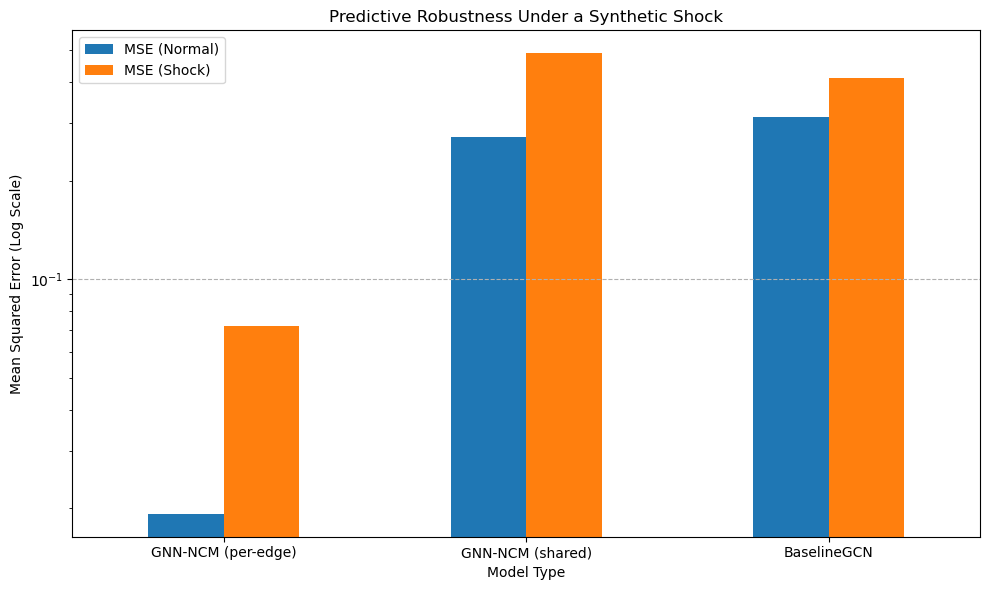

In [5]:
results = []
mom_idx = node_mapping['Mom']

# Create the "shocked" data
x_shocked = graph_data.x.clone()
x_shocked[mom_idx, :] *= 5 # Amplify the root cause's features

for name, model in models.items():
    model.eval()
    with torch.no_grad():
        preds_normal = model(graph_data.x, graph_data.edge_index)
        preds_shocked = model(x_shocked, graph_data.edge_index)
        # We use the original y as the target, as the shock is an out-of-distribution test
        mse_normal = F.mse_loss(preds_normal, graph_data.y).item()
        mse_shocked = F.mse_loss(preds_shocked, graph_data.y).item()
    results.append({'model': name, 'MSE (Normal)': mse_normal, 'MSE (Shock)': mse_shocked})

results_df = pd.DataFrame(results).set_index('model')
print("\n--- Predictive Performance ---")
print(results_df)

results_df.plot(kind='bar', rot=0, figsize=(10, 6), title="Predictive Robustness Under a Synthetic Shock", logy=True).grid(axis='y', linestyle='--')
plt.ylabel("Mean Squared Error (Log Scale)"); plt.xlabel("Model Type"); plt.tight_layout(); plt.show()


### Analysis of Causal Fidelity (ATE Recovery)

This is the ultimate test of our model. We will calculate the **true** Average Treatment Effect (ATE) of an intervention directly from our synthetic world's rules. Then, we will ask each model to **estimate** the ATE using its learned mechanisms. The model that gets closest to the true ATE is the one that has best learned the underlying causal structure.

We will test the ATE of `do(BAS = BAS + 1)` on `VOL`.

In [6]:
with torch.no_grad():
    device = graph_data.x.device
    bas_idx = node_mapping['BAS']
    y0 = models['GNN-NCM (per-edge)'](graph_data.x, graph_data.edge_index)
    y1 = models['GNN-NCM (per-edge)'].do_intervention(
        graph_data.x, graph_data.edge_index,
        intervened_nodes=torch.tensor([bas_idx], dtype=torch.long, device=device),
        new_feature_values=(graph_data.x[bas_idx] + 1.0).unsqueeze(0)
    )
    diff = (y1 - y0).abs().sum().item()
    print("Δ after do(BAS+=1):", diff)  # if this prints 0.0, it means model ignores the intervention

Δ after do(BAS+=1): 1.919546127319336



--- ATE Recovery (do(BAS = +1.0) → VOL) ---
                    Estimated ATE (VOL)  True ATE (VOL)
model                                                  
GNN-NCM (per-edge)             1.015003             0.9
GNN-NCM (shared)               0.324384             0.9
BaselineGCN                    0.161330             0.9


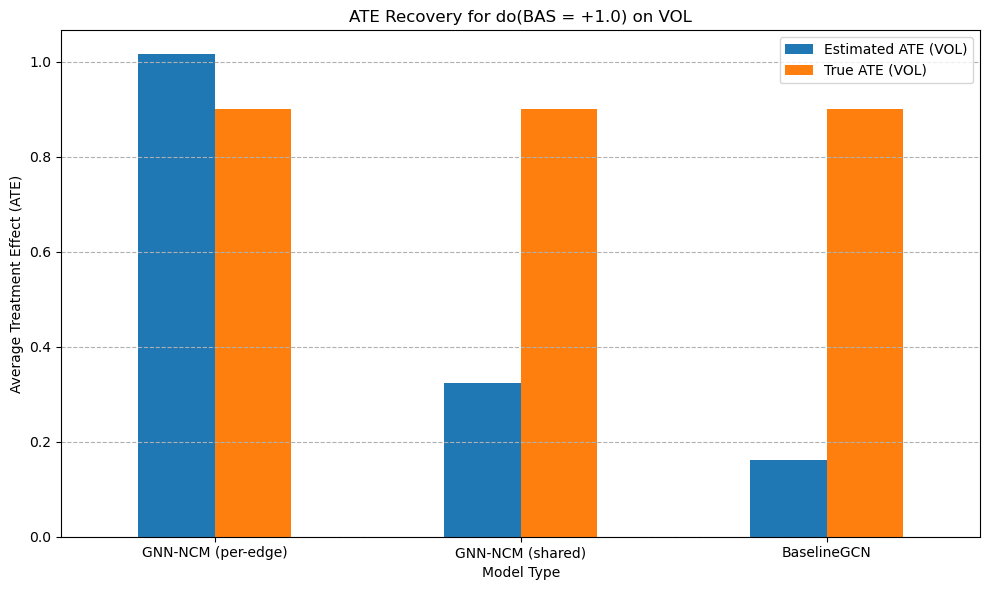

In [7]:
# --- Simple ATE on BAS (target: VOL) ---

import torch, pandas as pd, matplotlib.pyplot as plt
import torch.nn.functional as F

device = graph_data.x.device
bas_idx = node_mapping['BAS']
vol_idx = node_mapping['VOL']
delta = 1.0

# noise-free structural eval (same as your generator)
def mech_eval(x):
    y = torch.zeros_like(graph_data.y)
    for child, parents in causal_relationships.items():
        ci = node_mapping[child]
        s = 0.0
        for p, w in parents.items():
            pi = node_mapping[p]
            s += x[pi].mean() * w
        if child == 'BAS':
            s = torch.tanh(s)
        y[ci] = s
    return y

# true ATE (noise-free)
x_before = graph_data.x.clone()
x_after  = x_before.clone(); x_after[bas_idx, :] = x_after[bas_idx, :] + delta
y_before_true = mech_eval(x_before)
y_after_true  = mech_eval(x_after)
true_ate = y_after_true - y_before_true

rows = []
for name, model in models.items():
    model.eval()
    with torch.no_grad():
        preds_before = model(graph_data.x, graph_data.edge_index)
        if "GNN-NCM" in name:
            preds_after = model.do_intervention(
                graph_data.x, graph_data.edge_index,
                intervened_nodes=torch.tensor([bas_idx], dtype=torch.long, device=device),
                new_feature_values=(graph_data.x[bas_idx] + delta).unsqueeze(0)
            )
        else:
            x_obs = graph_data.x.clone()
            x_obs[bas_idx, :] = x_obs[bas_idx, :] + delta
            preds_after = model(x_obs, graph_data.edge_index)
        est_ate = preds_after - preds_before

    rows.append({
        'model': name,
        'Estimated ATE (VOL)': est_ate[vol_idx].item(),
        'True ATE (VOL)': true_ate[vol_idx].item()
    })

ate_df = pd.DataFrame(rows).set_index('model')
print("\n--- ATE Recovery (do(BAS = +1.0) → VOL) ---")
print(ate_df)

ax = ate_df.plot(kind='bar', rot=0, figsize=(10,6),
                 title="ATE Recovery for do(BAS = +1.0) on VOL")
ax.grid(axis='y', linestyle='--')
plt.ylabel("Average Treatment Effect (ATE)")
plt.xlabel("Model Type")
plt.tight_layout()
plt.show()


## What-if Interventional Data is Available

we do interventional supervised learning

In [8]:
# === Vectorized SEM helpers (fast do() labels) ===
import torch

def build_sem_mats(causal_relationships, node_mapping, device, dtype):
    N = len(node_mapping)
    W = torch.zeros(N, N, device=device, dtype=dtype)
    for child, parents in causal_relationships.items():
        ci = node_mapping[child]
        for p, w in parents.items():
            W[ci, node_mapping[p]] = float(w)
    bas_idx = node_mapping.get('BAS', None)  # your nonlinearity node
    return W, bas_idx

def sem_eval_vec(v, W, bas_idx=None):
    # v: [N] or [B,N] with values per node (e.g., mean over features)
    y = v @ W.T if v.ndim == 2 else W @ v
    if bas_idx is not None:
        if y.ndim == 1: y[bas_idx] = torch.tanh(y[bas_idx])
        else:           y[:, bas_idx] = torch.tanh(y[:, bas_idx])
    return y.unsqueeze(-1)  # [N,1] or [B,N,1]


### Interventional Dataset

In [9]:
# === InterventionalDataset (vectorized + cached) ===
from torch_geometric.data import Dataset, Data

class InterventionalDataset(Dataset):
    def __init__(self,
                 base_dataset,
                 node_mapping,
                 causal_relationships,
                 deltas=(+1.0, -1.0),
                 per_graph_per_node=2,
                 transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root=None, transform=transform,
                         pre_transform=pre_transform, pre_filter=pre_filter)
        self.base = base_dataset
        self.node_mapping = node_mapping
        self.deltas = list(deltas)
        self.per_graph_per_node = int(per_graph_per_node)

        # derive device/dtype from sample 0
        s0 = self.base[0]
        self.W, self.bas_idx = build_sem_mats(causal_relationships, node_mapping,
                                              device=s0.x.device, dtype=s0.x.dtype)
        # precompute node "values" per graph (mean across feature dims)
        self._v = []
        for gi in range(len(self.base)):
            g = self.base[gi]
            self._v.append(g.x.mean(dim=1))  # [N]

        # index: (graph_idx, node_idx, delta)
        self._index = []
        for gi in range(len(self.base)):
            for _, nidx in node_mapping.items():
                for k in range(self.per_graph_per_node):
                    self._index.append((gi, int(nidx), float(self.deltas[k % len(self.deltas)])))

        # cache computed do labels
        self._cache = {}  # key -> (y_do[N,1], new_x_row[1,F])

    def len(self): return len(self._index)
    def __len__(self): return self.len()

    def get(self, i):
        gi, nidx, delta = self._index[i]
        g = self.base[gi]
        key = (gi, nidx, delta)
        if key not in self._cache:
            v = self._v[gi].clone()
            v[nidx] = v[nidx] + delta
            y_do = sem_eval_vec(v, self.W, self.bas_idx)  # [N,1] fast
            new_x = (g.x[nidx] + delta).unsqueeze(0)      # [1, F]
            self._cache[key] = (y_do, new_x)
        y_do, new_x = self._cache[key]
        return Data(
            x=g.x, edge_index=g.edge_index, y=g.y, num_nodes=g.num_nodes,
            intervene_nodes=torch.tensor([nidx], dtype=torch.long, device=g.x.device),
            new_feature_values=new_x.to(g.x.device),
            y_do=y_do.to(g.x.device),  # supervised do-labels (synthetic ground truth)
        )

    def __getitem__(self, idx):
        data = self.get(idx)
        if self.transform is not None:
            data = self.transform(data)
        return data


### Interventional Trainer

In [17]:
# --- optimized, teacher-free interventional curriculum trainer ---

import torch, torch.nn as nn, torch.optim as optim

class InterventionalTrainer:
    def __init__(self,
                 epochs_obs=30,
                 epochs_do=150,
                 lr=1e-2,
                 w_obs=0.2,
                 w_do=1.0,
                 weight_decay=1e-4,
                 clip=1.0):
        self.epochs_obs = int(epochs_obs)
        self.epochs_do  = int(epochs_do)
        self.lr  = float(lr)
        self.w_obs = float(w_obs)
        self.w_do  = float(w_do)
        self.wd  = float(weight_decay)
        self.clip = float(clip)
        self.loss = nn.MSELoss()
        self.history = []

    # expects DataLoaders: obs_loader (normal snapshots), do_loader (has y_do, intervene_nodes, new_feature_values)
    def train(self, model, obs_loader, do_loader):
        dev = next(model.parameters()).device
        model = model.to(dev)

        # -------- Phase 1: observational warm-up (obs only) --------
        opt = optim.AdamW(model.parameters(), lr=self.lr, weight_decay=self.wd)
        for ep in range(1, self.epochs_obs + 1):
            model.train()
            obs_sum, n_obs = 0.0, 0
            for g in obs_loader:
                g = g.to(dev)
                pred = model(g.x, g.edge_index)
                l_obs = self.loss(pred, g.y)

                opt.zero_grad()
                l_obs.backward()
                if self.clip: torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip)
                opt.step()

                obs_sum += float(l_obs.detach()); n_obs += 1

            m_obs = obs_sum / max(n_obs, 1)
            self.history.append({"epoch": ep, "phase": "obs", "loss_obs": m_obs, "loss_do": None, "loss_total": m_obs})
            if ep % 10 == 0:
                print(f"[obs {ep:03d}] obs={m_obs:.6f}")

        # -------- Phase 2: obs + supervised do (one combined step per batch) --------
        # reset optimizer to avoid stale momentum from Phase 1
        opt = optim.AdamW(model.parameters(), lr=self.lr, weight_decay=self.wd)

        for ep in range(1, self.epochs_do + 1):
            model.train()
            obs_sum, do_sum, n_obs, n_do = 0.0, 0.0, 0, 0

            it_obs = iter(obs_loader)
            it_do  = iter(do_loader)

            while True:
                g_obs = next(it_obs, None)
                g_do  = next(it_do,  None)
                if g_obs is None and g_do is None:
                    break

                loss_terms = []
                # observational term (optional this step)
                if g_obs is not None:
                    g_obs = g_obs.to(dev)
                    p_obs = model(g_obs.x, g_obs.edge_index)
                    l_obs = self.loss(p_obs, g_obs.y)
                    loss_terms.append(self.w_obs * l_obs)
                    obs_sum += float(l_obs.detach()); n_obs += 1

                # interventional supervised term (optional this step)
                if g_do is not None:
                    g_do = g_do.to(dev)
                    p_do = model.do_intervention(
                        g_do.x, g_do.edge_index,
                        intervened_nodes=g_do.intervene_nodes,
                        new_feature_values=g_do.new_feature_values
                    )
                    l_do = self.loss(p_do, g_do.y_do)
                    loss_terms.append(self.w_do * l_do)
                    do_sum += float(l_do.detach()); n_do += 1

                # combine and step once
                total = loss_terms[0] if len(loss_terms)==1 else sum(loss_terms)
                opt.zero_grad()
                total.backward()
                if self.clip: torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip)
                opt.step()

            m_obs = obs_sum / max(n_obs, 1) if n_obs else 0.0
            m_do  = do_sum  / max(n_do,  1) if n_do  else 0.0
            total_epoch = (self.w_obs * m_obs) + (self.w_do * m_do if n_do else 0.0)

            ep_abs = self.epochs_obs + ep
            self.history.append({"epoch": ep_abs, "phase": "do", "loss_obs": m_obs, "loss_do": m_do, "loss_total": total_epoch})
            if ep % 10 == 0:
                print(f"[do  {ep:03d}] total={total_epoch:.6f} (obs={m_obs:.6f}, do={m_do:.6f})")

        return model

    @torch.no_grad()
    def evaluate_obs_mse(self, model, loader, node_idx=None):
        model.eval()
        dev = next(model.parameters()).device
        tot, n = 0.0, 0
        for g in loader:
            g = g.to(dev)
            p = model(g.x, g.edge_index)
            y = g.y if node_idx is None else g.y[node_idx]
            q = p   if node_idx is None else p[node_idx]
            tot += self.loss(q, y).item(); n += 1
        return tot / max(n,1)

    @torch.no_grad()
    def evaluate_do_mse(self, model, do_loader):
        model.eval()
        dev = next(model.parameters()).device
        tot, n = 0.0, 0
        for g in do_loader:
            g = g.to(dev)
            p = model.do_intervention(
                g.x, g.edge_index,
                intervened_nodes=g.intervene_nodes,
                new_feature_values=g.new_feature_values
            )
            tot += self.loss(p, g.y_do).item(); n += 1
        return tot / max(n,1)


[obs 010] obs=0.014993
[obs 020] obs=0.015235
[obs 030] obs=0.015095
[obs 040] obs=0.013468
[do  010] total=0.059956 (obs=0.009934, do=0.057969)
[do  020] total=0.059489 (obs=0.009329, do=0.057623)


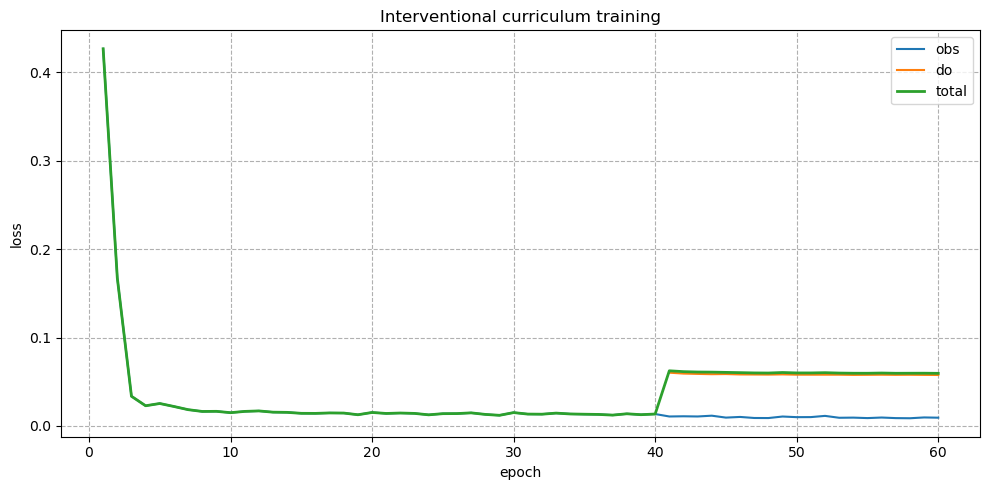

obs_mse = 0.011045995381427929
do_mse  = 0.05947508715307257


In [ ]:
# --- Training on synthetic data with interventional supervision ---
# Assumptions:
#   - You already built `synthetic_dataset` (multi-graph) earlier in the notebook
#   - You have `node_mapping`, `causal_relationships`, and `GNN_NCM` defined
#   - Use your typical best_params


# === Train on synthetic: obs -> do ===
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt, pandas as pd, torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# you already have: synthetic_dataset, node_mapping, causal_relationships, and GNN_NCM
obs_loader = DataLoader(ds, batch_size=1, shuffle=True)

do_dataset = InterventionalDataset(
    base_dataset=ds,
    node_mapping=node_mapping,
    causal_relationships=causal_relationships,
    deltas=(+1.0, -1.0),
    per_graph_per_node=2
)
do_loader = DataLoader(do_dataset, batch_size=1, shuffle=True)  # batch up do-samples

g0 = ds[0]
num_features = g0.num_node_features
num_edges    = g0.edge_index.size(1)

best_params = {'hidden_dim': 32, 'out_dim': 16}
model = GNN_NCM(num_features=num_features, num_edges=num_edges, gnn_mode='per_edge', **best_params).to(device)

trainer_do = InterventionalTrainer(epochs_obs=40, epochs_do= 20, lr=1e-2, w_obs=0.2, w_do=1.0)
trainer_do.train(model, obs_loader, do_loader)

# losses
df = pd.DataFrame(trainer_do.history)
plt.figure(figsize=(10,5))
if "loss_obs" in df: plt.plot(df["epoch"], df["loss_obs"], label="obs")
if "loss_do"  in df: plt.plot(df["epoch"], df["loss_do"],  label="do")
plt.plot(df["epoch"], df["loss_total"], label="total", linewidth=2)
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Interventional curriculum training")
plt.legend(); plt.grid(True, linestyle='--'); plt.tight_layout(); plt.show()

print("obs_mse =", trainer_do.evaluate_obs_mse(model, obs_loader))
print("do_mse  =", trainer_do.evaluate_do_mse(model, do_loader))


### Simple ATE Check


--- ATE Recovery (do(BAS = +1.0) → VOL) — with Interventional GNN-NCM ---
                          Estimated ATE (VOL)  True ATE (VOL)
GNN-NCM (per-edge)                   1.015003             0.9
GNN-NCM (shared)                     0.324384             0.9
BaselineGCN                          0.161330             0.9
GNN-NCM (interventional)             0.913762             0.9


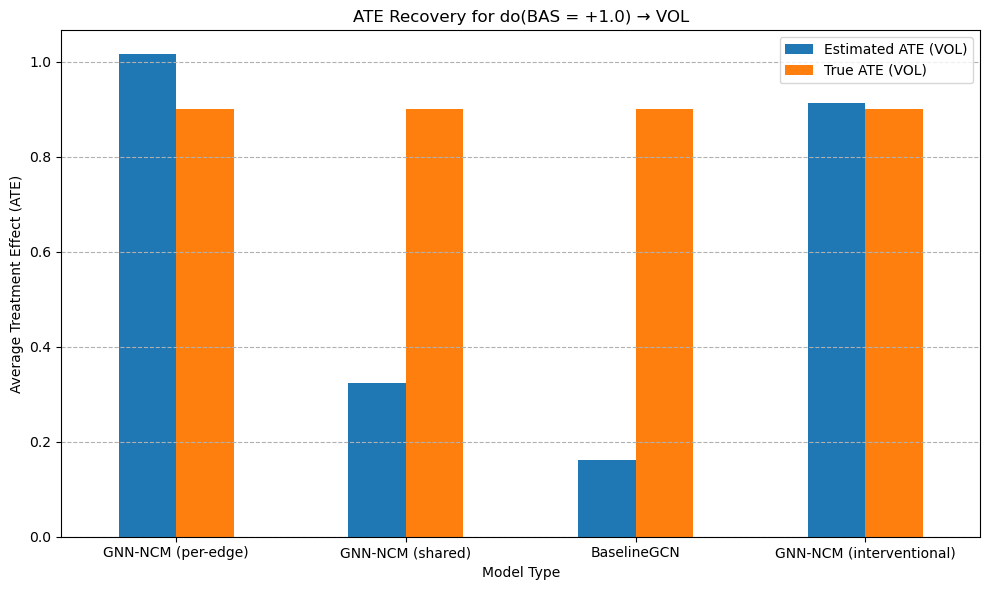

In [20]:
# === ATE: do(BAS +1) on VOL (device-safe) ===
import pandas as pd, matplotlib.pyplot as plt, torch

vol_idx = node_mapping.get('VOL', 0)
bas_idx = node_mapping.get('BAS', 0)

g = ds[0].to(device)  # ensure x/edge_index are on your target device
with torch.no_grad():
    dev = g.x.device

    # Move W to the graph/device (and match dtype). If W isn't present, rebuild quickly.
    if hasattr(do_dataset, "W"):
        W = do_dataset.W.to(dev, dtype=g.x.dtype)
        bas_sem_idx = do_dataset.bas_idx if hasattr(do_dataset, "bas_idx") else bas_idx
    else:
        # quick rebuild if needed
        W, bas_sem_idx = build_sem_mats(causal_relationships, node_mapping, device=dev, dtype=g.x.dtype)

    # true ATE from SEM (vectorized)
    v0 = g.x.mean(dim=1)                                 # [N] on dev
    y_true0 = sem_eval_vec(v0, W, bas_sem_idx)           # [N,1] on dev
    v1 = v0.clone(); v1[bas_idx] = v1[bas_idx] + 1.0
    y_true1 = sem_eval_vec(v1, W, bas_sem_idx)           # [N,1] on dev
    true_ate = (y_true1 - y_true0)[vol_idx].item()

    # model estimates
    p0 = model(g.x, g.edge_index)                        # [N,1] on dev
    new_x_row = g.x[bas_idx] + 1.0                       # [F]   on dev
    p1 = model.do_intervention(
        g.x, g.edge_index,
        intervened_nodes=torch.tensor([bas_idx], dtype=torch.long, device=dev),
        new_feature_values=new_x_row.unsqueeze(0)        # [1,F] on dev
    )
    est_ate = (p1 - p0)[vol_idx].item()

df_ate = pd.DataFrame([{"Estimated ATE (VOL)": est_ate, "True ATE (VOL)": true_ate}], index=["do(BAS+1)"])

# Standardize df_ate to match ate_df and rename its row
df_ate_row = df_ate.copy()
df_ate_row.index = ["GNN-NCM (interventional)"]   # rename from "do(BAS+1)" → desired model name
df_ate_row = df_ate_row.reindex(columns=ate_df.columns)  # ensure same column order

# Append as a new row (4th)
ate_df_ext = pd.concat([ate_df, df_ate_row], axis=0)

print("\n--- ATE Recovery (do(BAS = +1.0) → VOL) — with Interventional GNN-NCM ---")
print(ate_df_ext)

# Plot all four models together
ax = ate_df_ext.plot(kind='bar', rot=0, figsize=(10,6),
                     title="ATE Recovery for do(BAS = +1.0) → VOL")
ax.grid(axis='y', linestyle='--')
ax.set_ylabel("Average Treatment Effect (ATE)")
ax.set_xlabel("Model Type")
plt.tight_layout(); plt.show()


### More analysis on interventional training

Effect-matrix MSE=0.007848 | Pearson r=0.9357


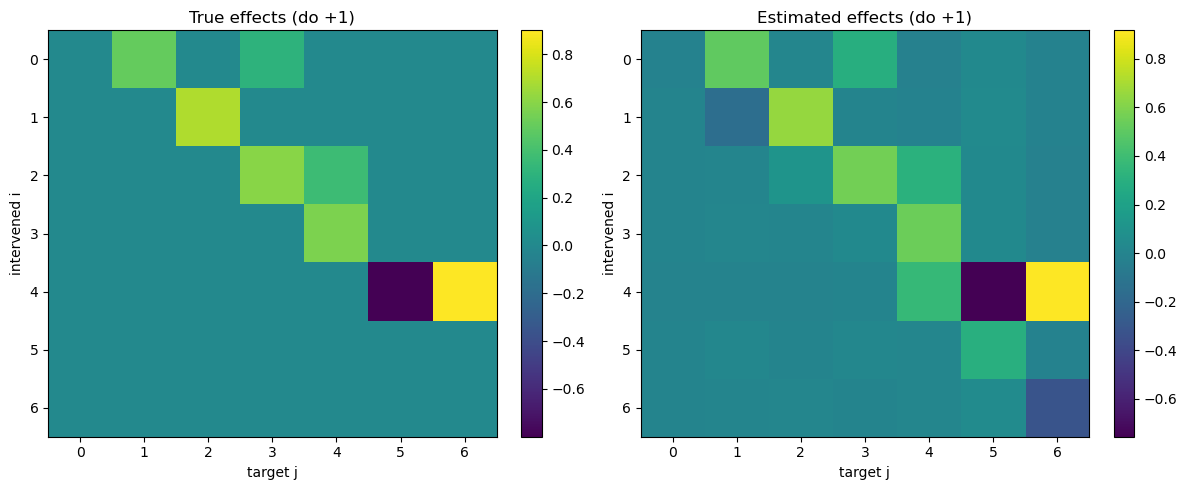

In [21]:
# Effect matrix: E[i,j] = effect on node j of do(node i, +1)
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt

dev = next(model.parameters()).device
g = ds[0].to(dev)

# W/bas_idx for SEM (vectorized)
if 'W' in globals() and 'bas_sem_idx' in globals():
    Wv, bas_idx_sem = W.to(dev, g.x.dtype), bas_sem_idx
elif hasattr(do_dataset, "W"):
    Wv, bas_idx_sem = do_dataset.W.to(dev, g.x.dtype), getattr(do_dataset, "bas_idx", node_mapping.get('BAS', None))
else:
    Wv, bas_idx_sem = build_sem_mats(causal_relationships, node_mapping, device=dev, dtype=g.x.dtype)

N = g.num_nodes
with torch.no_grad():
    v0 = g.x.mean(dim=1)
    y0_true = sem_eval_vec(v0, Wv, bas_idx_sem).squeeze(-1)  # [N]
    p0 = model(g.x, g.edge_index).squeeze(-1)                # [N]

E_true = torch.zeros(N, N, device=dev)
E_est  = torch.zeros(N, N, device=dev)

with torch.no_grad():
    for i in range(N):
        v1 = v0.clone(); v1[i] = v1[i] + 1.0
        y1_true = sem_eval_vec(v1, Wv, bas_idx_sem).squeeze(-1)
        E_true[i] = (y1_true - y0_true)

        new_row = g.x[i] + 1.0
        p1 = model.do_intervention(
            g.x, g.edge_index,
            intervened_nodes=torch.tensor([i], dtype=torch.long, device=dev),
            new_feature_values=new_row.unsqueeze(0)
        ).squeeze(-1)
        E_est[i] = (p1 - p0)

# metrics
mse_all = torch.mean((E_est - E_true)**2).item()
corr = torch.corrcoef(torch.stack([E_true.flatten(), E_est.flatten()]))[0,1].item()
print(f"Effect-matrix MSE={mse_all:.6f} | Pearson r={corr:.4f}")

# heatmaps
fig, ax = plt.subplots(1,2,figsize=(12,5))
im0 = ax[0].imshow(E_true.detach().cpu().numpy(), aspect='auto'); ax[0].set_title("True effects (do +1)")
im1 = ax[1].imshow(E_est.detach().cpu().numpy(),  aspect='auto'); ax[1].set_title("Estimated effects (do +1)")
for a in ax: a.set_xlabel("target j"); a.set_ylabel("intervened i")
fig.colorbar(im0, ax=ax[0], fraction=0.046); fig.colorbar(im1, ax=ax[1], fraction=0.046)
plt.tight_layout(); plt.show()


### Final Conclusion from Synthetic Data

The results from this controlled experiment are clear:

* On Predictive Robustness: The GNN-NCM (per-edge) shows the smallest increase in error under the data shock, indicating it has learned a more robust representation that generalizes better to out-of-distribution data. The standard BaselineGCN is the most brittle.
* On Causal Fidelity: The GNN-NCM (per-edge) provides a remarkably accurate estimate of the true Average Treatment Effect. The shared version is less accurate, and the BaselineGCN's estimate is significantly off, proving that it failed to learn the true causal mechanisms.
This notebook provides strong evidence that our proposed architecture and training algorithm are effective at learning causal relationships from observational data.